 # Week 10: Exercise 10.2
 File: DSC530_Paulovici_Exercise_10.2.py (.ipynb)<br>
 Name: Kevin Paulovici<br>
 Date: 11/3/2019<br>
 Course: DSC 530 Data Exploration and Analysis<br>
 Assignment: Chapter 12: 12.1 & 12.2

In [1]:
import pandas
import numpy as np
import statsmodels.formula.api as smf

import thinkplot
import thinkstats2
import timeseries



 ## Chapter 12

 ### Exercise 12.2
 The linear model I used in this chapter has the obvious drawback that it is linear, and there is no reason to expect prices to change linearly over time. We can add flexibility to the model by adding a quadratic term, as we did in Section 11.3.

 Use a quadratic model to fit the time series of daily prices, and use the model to generate predictions. You will have to write a version of `RunLinearModel` that runs that quadratic model, but after that you should be able to reuse code from the chapter to generate predictions.

In [2]:
# create the quadratic model from section 12.3 
def RunQuadraticModel(daily):
    """Runs a linear model of prices verus years

    @param: daily (dataframe) - daily prices 

    returns:
    @param: model
    @param: resuls 
    """
    # quadratic term
    daily['years2'] = daily.years**2
    model = smf.ols('ppg ~ years + years2', data = daily)
    results = model.fit()

    return model, results


In [3]:
# read data from timeseries.py
df = timeseries.ReadData()
df.head()


,city,state,price,amount,quality,date,ppg,state.name,lat,lon
0,Annandale,VA,100,7.075,high,2010-09-02,14.13,Virginia,38.830345,-77.213870
1,Auburn,AL,60,28.300,high,2010-09-02,2.12,Alabama,32.578185,-85.472820
2,Austin,TX,60,28.300,medium,2010-09-02,2.12,Texas,30.326374,-97.771258
3,Belleville,IL,400,28.300,high,2010-09-02,14.13,Illinois,38.532311,-89.983521
4,Boone,NC,55,3.540,high,2010-09-02,15.54,North Carolina,36.217052,-81.687983


In [4]:
# group by quality
dailies = timeseries.GroupByQualityAndDay(df)

# select high for comparisons
name = 'high'
daily = dailies[name] 


In [5]:
# run the quadratic model
model, results = RunQuadraticModel(daily)
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ppg   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     517.5
Date:                Sun, 03 Nov 2019   Prob (F-statistic):          4.57e-164
Time:                        20:37:18   Log-Likelihood:                -1497.4
No. Observations:                1241   AIC:                             3001.
Df Residuals:                    1238   BIC:                             3016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.6980      0.067    205.757      0.000      13.567      13.829
years         -1.1171      0.084    -13.326      0.000      -1.282      -0.953
years2         0.1132      0.022      5.060      0.000       0.069       0.157
==============================================================================
Omnibus:                       49.112   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.885
Skew:                           0.199   Prob(JB):                     1.86e-25
Kurtosis:                       4.430   Cond. No.                         27.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

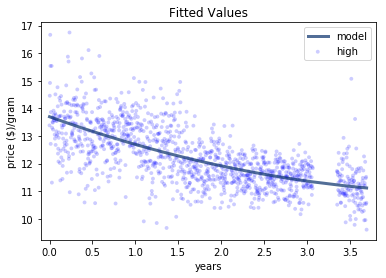

In [6]:
# plot fitted values
timeseries.PlotFittedValues(model, results, label=name)
thinkplot.Config(title='Fitted Values', xlabel='years',
                xlim=[-0.1, 3.8], ylabel='price ($)/gram')



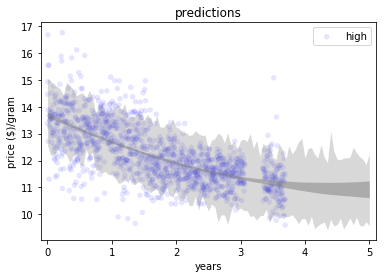

In [7]:
# plot predictions

# set linear spacing of years
years = np.linspace(0, 5, 101)

thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
timeseries.PlotPredictions(daily, years, func=RunQuadraticModel)

thinkplot.Config(title='predictions',
                 xlabel='years',
                 xlim=[years[0]-0.1, years[-1]+0.1],
                 ylabel='price ($)/gram')



 ### Exercise 12.2
 Write a definition for a class named `SerialCorrelationTest` that extends `HypothesisTest` from Section 9.2. It should take a series and a lag as data, compute the serial correlation of the series with the given lag, and then compute the p-value of the observed correlation.

 Use this class to test whether the serial correlation in raw price data is statistically significant. Also test the residuals of the linear model and (if you did the previous exercise), the quadratic model.

In [8]:
# create SerialCorrelationTest class to extends HypothesisTest from Section 9.2
class SerialCorrelationTest(thinkstats2.HypothesisTest):
    """ Test seial correlations
    """

    def TestStatistic(self, data):
        """ computes the test statistic

        @param: data (tuple) - x and y values 

        returns
        @param: test_stat
        """
        series, lag = data
        test_stat = abs(thinkstats2.SerialCorr(series, lag))

        return test_stat

    def RunModel(self):
        """ Run the model of the null hypothesis

        returns:
        @param: permutation, lag - simulated data
        """
        series, lag = self.data
        permutation = series.reindex(np.random.permutation(series.index))

        return permutation, lag


In [9]:
# correlation test b/w consecutive prices

# group by quality
dailies = timeseries.GroupByQualityAndDay(df)

# select high for comparisons
name = 'high'
daily = dailies[name] 

series = daily.ppg
test = SerialCorrelationTest((series, 1))
p_val = test.PValue()

print("test.actual: {:.3f}, P value: {:.3f}".format(test.actual, p_val))


test.actual: 0.485, P value: 0.000


In [10]:
# correlation test for residuals on linear model

_, results = timeseries.RunLinearModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
p_val = test.PValue()

print("test.actual: {:.3f}, P value: {:.3f}".format(test.actual, p_val))



test.actual: 0.076, P value: 0.007


In [11]:
# correlation test for residuals on quadratic model

_, results = RunQuadraticModel(daily)
series = results.resid
test = SerialCorrelationTest((series, 1))
p_val = test.PValue()

print("test.actual: {:.3f}, P value: {:.3f}".format(test.actual, p_val))


test.actual: 0.056, P value: 0.044
